**Sharpe Ratio evaluation for Tesla versus competitors**

Method to calculate Sharpe ratio using python comes from https://projects.datacamp.com/projects/66

Daily data is coming from https://finance.yahoo.com/quote/TSLA/history?p=TSLA  First pass data was exported on 9-Nov-2023.  I may do another pass where I download it for the day with web scraping.  That would be cool!

List of Tesla competitors came from here:  https://money.usnews.com/investing/stock-market-news/slideshows/upstart-tesla-competitors-to-watch

Great article on data cleaning:  https://towardsdatascience.com/data-cleaning-with-python-and-pandas-detecting-missing-values-3e9c6ebcf78b#:~:text=Using%20the%20isnull()%20method,NA%E2%80%9D%20types%20as%20missing%20values.

**Shared functions -- find out how to put this in a different file, if possible.**

In [28]:
# Shared import function -- find out how to put this in a different file, if possible.
def import_df(file_name, cols,dayfirst=True,is_verbose=False):

    import pandas as pd
    import csv
    import numpy as np
    # Making a list of missing value types
    missing_values = ["n/a", "na", "-"]
    
    #import data
    df = pd.read_csv(file_name
                     ,thousands=','
                     ,dtype=str
                     ,na_values = missing_values
                    ).fillna(0)
    df = df[cols]
 
    #rename columns
    df.rename(columns={'Adj Close**':'Close'}, inplace=True)
    df.rename(columns={'Adj Close':'Close'}, inplace=True)
    
    #convert date to datetime
    df['Date'] = pd.to_datetime(df['Date'],format='mixed',dayfirst=dayfirst)
    
    #convert close to float
    df['Close'].replace(',','',regex=True,inplace=True)
    df['Close'] = pd.to_numeric(df['Close'])

    # Convert volume to int, checking for unexpected values--there is something funky here.  Possibly revisit.
    df['Volume'].replace(',','',regex=True,inplace=True)
    cnt=0
    for row in df['Volume']:
        try:
            df.loc[cnt, 'Volume']=int(row)
        except ValueError:
            df.loc[cnt, 'Volume']=np.nan
        if(df.loc[cnt, 'Volume']==0):
            df.loc[cnt, 'Volume']=np.nan
        cnt+=1
    df['Volume'] = pd.to_numeric(df['Volume'])  

    #debugging stuff 
    #print(df.isna())
    #print(df.isnull().sum())
    
    # Replace nulls using median 
    median = df['Volume'].median()
    df['Volume'].fillna(median, inplace=True)
    df.set_index('Date',inplace=True)

    if(is_verbose):
        print(file_name + ' info:')
        print(df.info())
         #print(df.head())
        print('\n')

    return df







**Start of actual code**

_Import librariess_

In [29]:
#import libraries
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt

_Placeholder:  scrape data off of S&P site_
(may not be readily doable--come back to it)

_Import CSV files_

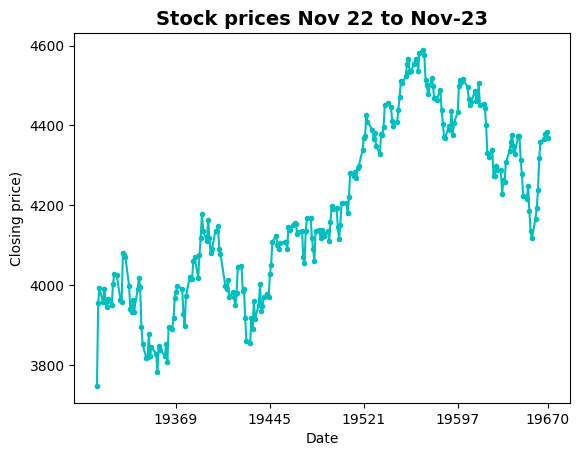

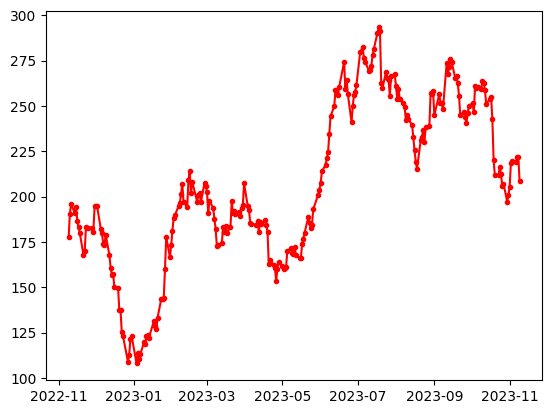

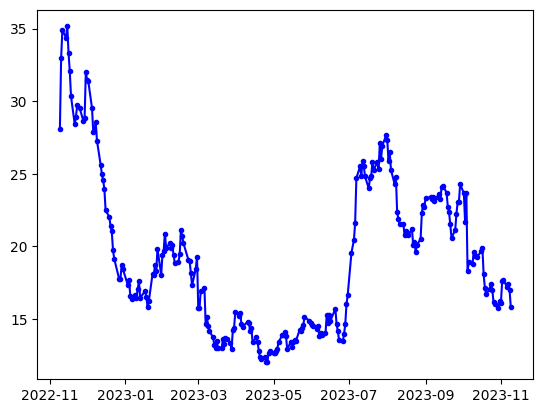

In [30]:
#import data
cols_asterisk = ['Date','Adj Close**','Volume']
cols_no_asterisk = ['Date','Adj Close','Volume']

#import S&P as benchmark
benchmark_data = import_df('snp_data_22nov_23nov.csv', cols_asterisk)

#import Tesla and Rivian
tesla = import_df('tesla_data_22nov_23nov.csv', cols_asterisk)
rivn = import_df('rivn_data_22nov_23nov.csv', cols_no_asterisk,dayfirst=False)

# change the x ticks
plt.xticks(benchmark_data.index[::52])

# add X and Y labels 
plt.ylabel('Closing price)')
plt.xlabel('Date')

# add a title to the Plot 
plt.title('Stock prices Nov 22 to Nov-23', fontdict={'fontweight': 'bold', 'fontsize':14})

# add a legend 
# plt.legend()



# plot closing prices 
plt.plot(benchmark_data.index.values, benchmark_data.Close, 'c.-', label = 'S&P 500')
plt.show()
plt.plot(tesla.index.values,tesla.Close, 'r.-', label = 'Tesla')
plt.show()
plt.plot(rivn.index.values,rivn.Close, 'b.-',label = 'Rivn')
plt.show()

# save your graph (if you want to)
# plt.savefig('PricePlot.png', dpi=300)




_Prep the data for calculations - merge stock DataFrames and calculate returns for stocks and benchmark_

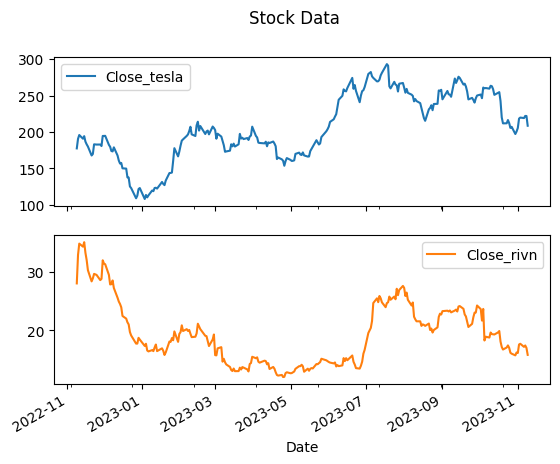

In [31]:
#merge Tesla and Rivian (add other stocks later)
stock_data = tesla.merge(rivn, how='outer', left_index=True, right_index=True, suffixes=('_tesla', '_rivn'))

# print(stock_data.head())

# visualize the stock_data
stock_data[['Close_tesla','Close_rivn']].plot(subplots=True,title='Stock Data');

# summarize the stock_data
#print('Stock data summary:')
# print(stock_data.describe())

# benchmark_data['Close'].plot(subplots=True,title='SMP Benchmark Data');

# print('Benchmark data summary:')
# print(benchmark_data.describe())

# calculate daily stock_data returns
stock_returns = stock_data.pct_change()

# plot the daily returns
#stock_returns.plot(subplots=True,title='Stock Returns');

# summarize the daily returns
# print('Stock returns summary:')
# print(stock_returns.describe())

# calculate daily benchmark_data returns
sp_returns = benchmark_data['Close'].pct_change()
# print('Benchmark returns summary')
# print(sp_returns)
# sp_returns.plot(title='S&P 500 Returns');

_Calculate excess returns_

In [32]:
df_excess = stock_returns.sub(sp_returns, axis=0)
# df_excess[['Close_tesla','Close_rivn']].plot(subplots=True,title='Excess Returns');


The Sharpe Ratio, Step 1: The Average Difference in Daily Returns Stocks vs S&P 500

Now we can finally start computing the Sharpe Ratio. First we need to calculate the average of the excess_returns. This tells us how much more or less the investment yields per day compared to the benchmark.


In [33]:
# calculate the mean of excess_returns 
# ... YOUR CODE FOR TASK 8 HERE ...
avg_excess_return = df_excess[['Close_tesla','Close_rivn']].mean()

# plot avg_excess_returns
# avg_excess_return.plot.bar(title='Mean of the Return Difference');

The Sharpe Ratio, Step 2: Standard Deviation of the Return Difference

It looks like there was quite a bit of a difference between average daily returns for Amazon and Facebook.

Next, we calculate the standard deviation of the excess_returns. This shows us the amount of risk an investment in the stocks implies as compared to an investment in the S&P 500.

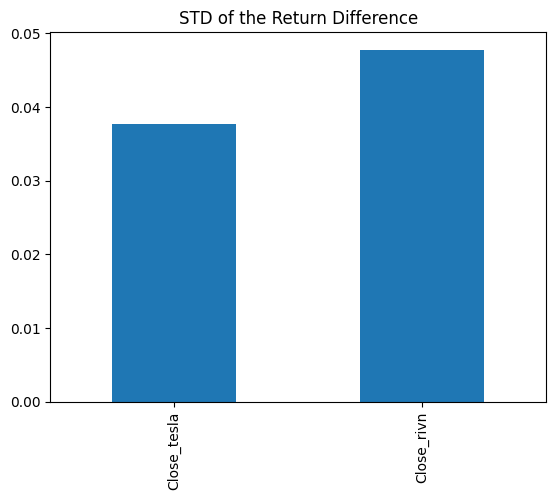

In [34]:
sd_excess_return = df_excess[['Close_tesla','Close_rivn']].std()
sd_excess_return.plot.bar(title='STD of the Return Difference');

10. Putting it all together

Now we just need to compute the ratio of avg_excess_returns and sd_excess_returns. The result is now finally the Sharpe ratio and indicates how much more (or less) return the investment opportunity under consideration yields per unit of risk.

The Sharpe Ratio is often annualized by multiplying it by the square root of the number of periods. We have used daily data as input, so we'll use the square root of the number of trading days (5 days, 52 weeks, minus a few holidays): √252

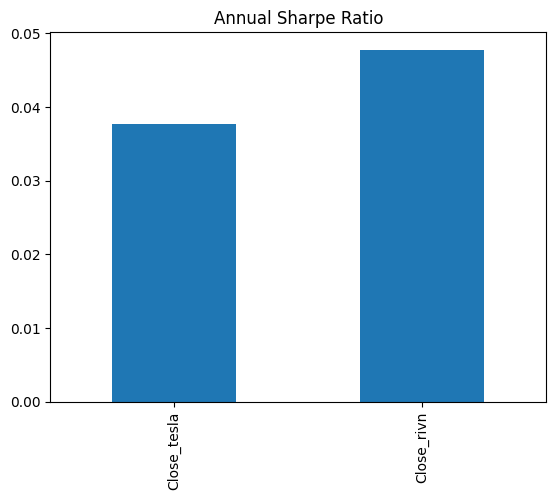

In [35]:
import math
daily_sharpe_ratio = avg_excess_return.div(sd_excess_return)
annual_factor = math.sqrt(252)
annual_sharpe_ratio = daily_sharpe_ratio.mul(annual_factor)

sd_excess_return.plot.bar(title='Annual Sharpe Ratio');